In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt

Define message signal

In [56]:


# message signal properties

message_frequency_cosine = 100  # in Hertz (Hz)
message_frequency_sine = 25     # in Hertz (Hz)
message_amplitude_cosine = -1   # (usually) in Volts (V)
message_amplitude_sine = 1      # (usually) in Volts (V)


# the component with the highest frequency carries the bandwidth

bandwidth = max(message_frequency_cosine, message_frequency_sine)   # in Hertz (Hz)
sampling_frequency = 2 * bandwidth        # Nyquist sampling frequency in Hertz (Hz)


# initialize the time vector

signal_duration = 2             # in seconds (s)

# sampling starts from t_0 = Ts
time = np.arange(start = 1, stop = signal_duration * sampling_frequency) / sampling_frequency


# calculate the message signal

message_cosine = message_amplitude_cosine * np.cos(2 * np.pi * message_frequency_cosine * time)
message_sine = message_amplitude_sine * np.sin(2 * np.pi * message_frequency_sine * time)
message = message_cosine + message_sine


# calculate the new message signal with higher time sensitivity

new_frequency = 1e6
new_time = np.arange(start = 1, stop = signal_duration * new_frequency) / new_frequency
new_message_cosine = message_amplitude_cosine * np.cos(2 * np.pi * message_frequency_cosine * new_time)
new_message_sine = message_amplitude_sine * np.sin(2 * np.pi * message_frequency_sine * new_time)
new_message = new_message_cosine + new_message_sine


# calculate the negative and positive peak values using new message signal for more accuracy

amplitude_pmax = np.amax(new_message)   # find the positive peak amplitude
amplitude_nmax = np.amin(new_message)   # find the negative peak amplitude

Define Pulse Code Modulation (PCM) properties

In [57]:
L = 128                           # number of quantization levels
no_of_bits = int(math.log2(L))    # number of bits (2^n = L)
level_limits = np.linspace(amplitude_pmax, amplitude_nmax, L + 1)     # L + 1 level limits


# take averages of the successive level limits to obtain quantization levels

quantization_levels = (level_limits[:L] + level_limits[1:]) / 2

Define the actual modulator

In [58]:
# define the quantized message signal

quantized_message = np.zeros_like(message)


# go through the modulation loop

for i in range(len(message)):
  amplitude_diffs = np.abs(message[i] - quantization_levels)

  # find the first index where the amplitude difference is greater than or equal to the one before it
  # if such index doesn't exist then set the quantized level as L - 1,
  # otherwise set the quantized level as the index before the one we have just found
  quantized_level = np.where(amplitude_diffs[1:] >= amplitude_diffs[:(L - 1)])[0]
  if quantized_level.size == 0:
    quantized_message[i] = L - 1
  elif quantized_level[0] > 1:
    quantized_message[i] = quantized_level[0]

Display the binary representation of the first 10 samples on the screen

In [59]:
output = [(np.binary_repr(int(quantized_message[i]), no_of_bits)) for i in range(10)]
print(*output, sep = "-")

0000000-0111011-0000000-1011101-0110001-1111111-0110001-1011101-0000000-0111011


Delta modulation

Define message signal

In [60]:
# initialize the time vector

sampling_frequency = 1e6        # in Hertz (Hz)
signal_duration = 2             # in seconds (s)
time = np.arange(signal_duration * sampling_frequency) / sampling_frequency


# message signal properties

message_frequency_cosine = 100  # in Hertz (Hz)
message_frequency_sine = 25     # in Hertz (Hz)
message_amplitude_cosine = -1   # (usually) in Volts (V)
message_amplitude_sine = 1      # (usually) in Volts (V)


# calculate the message signal

message_cosine = message_amplitude_cosine * np.cos(2 * np.pi * message_frequency_cosine * time)
message_sine = message_amplitude_sine * np.sin(2 * np.pi * message_frequency_sine * time)
message = message_cosine + message_sine

Define Delta Modulation (DM) properties

In [61]:
# the component with the highest frequency carries the bandwidth

bandwidth = max(message_frequency_cosine, message_frequency_sine)   # in Hertz (Hz)


# define delta sampling frequency as 4 times the Nyquist rate

nyquist_rate_factor = 4
delta_sampling_frequency = nyquist_rate_factor * 2 * bandwidth      # in Hertz (Hz)


delta_epsilon = 0.2     # define step size in seconds (s)

Define the actual modulator

In [62]:
# define sample time array

delta_time = np.arange(signal_duration * delta_sampling_frequency) / delta_sampling_frequency


# calculate the sampled message signal

sampled_message_cosine = message_amplitude_cosine * np.cos(2 * np.pi * message_frequency_cosine * delta_time)
sampled_message_sine = message_amplitude_sine * np.sin(2 * np.pi * message_frequency_sine * delta_time)
sampled_message = sampled_message_cosine + sampled_message_sine


# allocate memory

prediction = np.zeros((len(sampled_message), 1))
modulated = np.zeros_like(prediction)


# go through the modulation loop

for i, s_amplitude in enumerate(sampled_message[1:]):
  amplitude_diff = s_amplitude - prediction[i]
  modulated[i + 1] = (2 * int(amplitude_diff > 0) - 1) * delta_epsilon
  prediction[i + 1] = prediction[i] + modulated[i + 1]

C:\Users\Yadav\AppData\Local\Temp\ipykernel_3364\972571222.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modulated[i + 1] = (2 * int(amplitude_diff > 0) - 1) * delta_epsilon


Print the first 20 samples on the screen

In [63]:
output = [int(modulated[i] > 0) for i in range(1, 21)]
print(*output, sep="-")
     

0-1-1-1-1-1-0-0-0-1-1-1-1-0-0-0-0-0-1-1


C:\Users\Yadav\AppData\Local\Temp\ipykernel_3364\3934525284.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = [int(modulated[i] > 0) for i in range(1, 21)]


Plot obtained signals (optional)

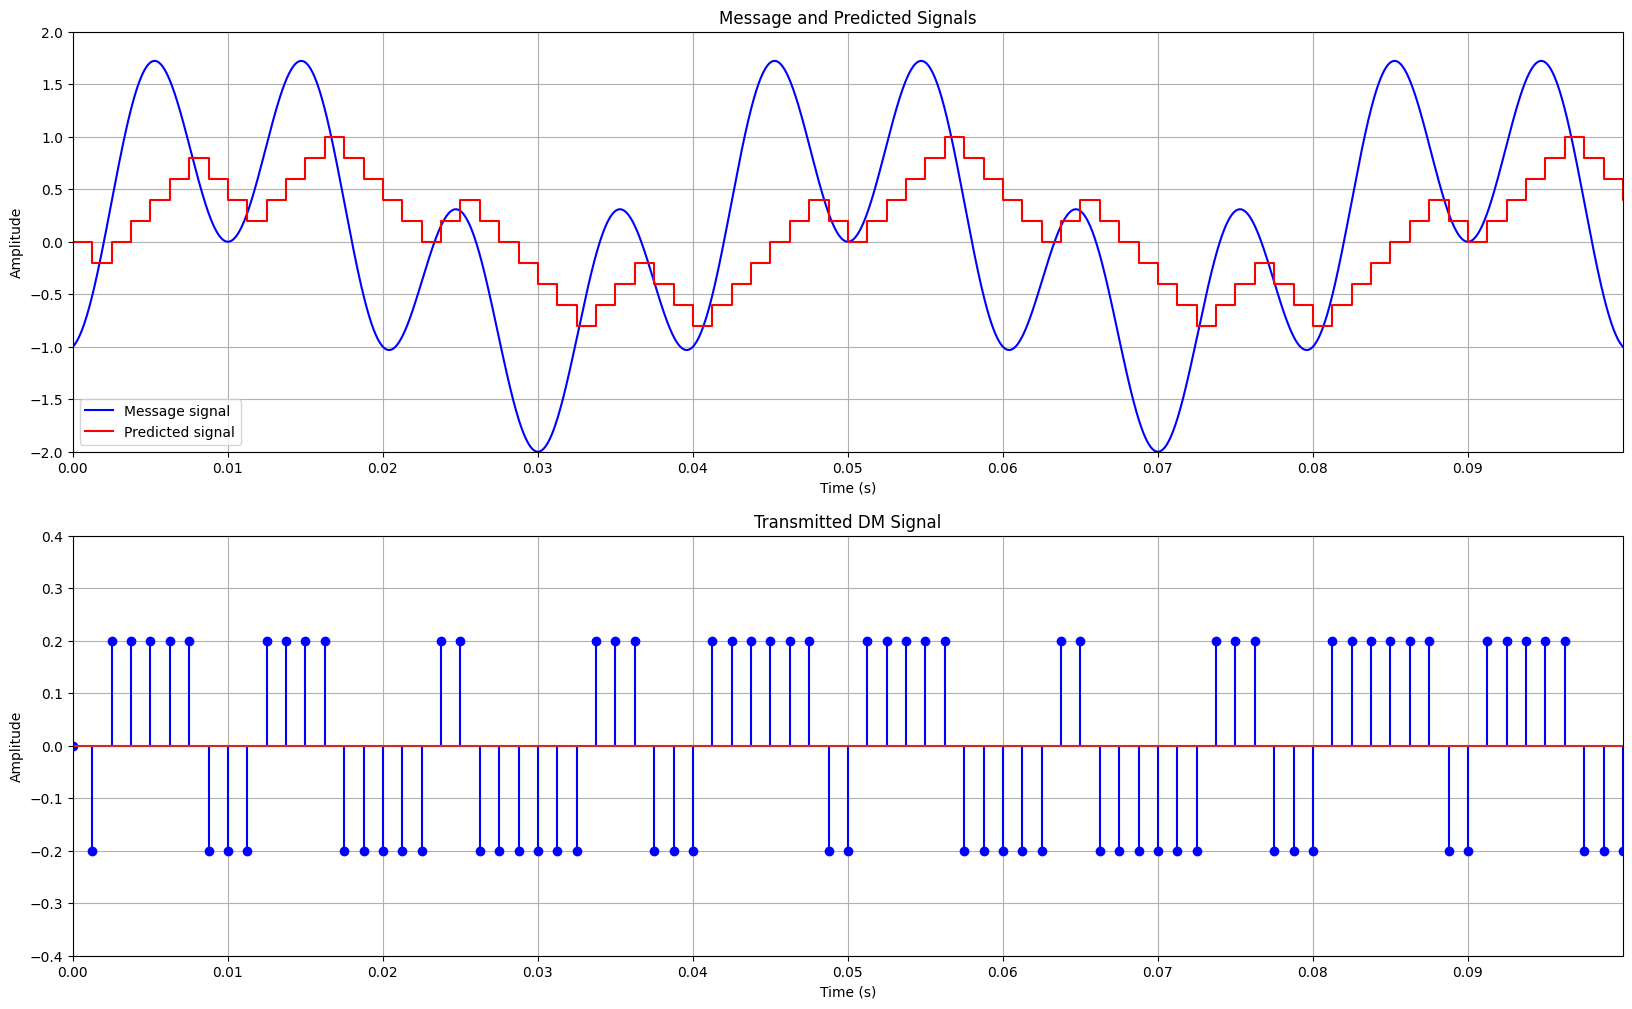

In [64]:
plt.figure(figsize = (20, 12))
plot_time = 0.1
# plot the message and predicted signals

plt.subplot(2, 1, 1)
plt.plot(time, message, 'b')
# plt.step(delta_time, sampled_message, 'c--', where = 'post')
plt.step(delta_time, prediction, 'r', where = 'post')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Message and Predicted Signals')
plt.legend(['Message signal', 'Predicted signal'])
plt.axis([0, plot_time, -2, 2])
plt.xticks(np.arange(0, plot_time, plot_time/10))
plt.grid()


# plot the transmitted DM signal

plt.subplot(2, 1, 2)
plt.stem(delta_time, modulated, 'b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Transmitted DM Signal')
plt.axis([0, plot_time, -2*delta_epsilon, 2*delta_epsilon])
plt.xticks(np.arange(0, plot_time, plot_time/10))
plt.grid()